We have introduced the basics of RNNs, which can better handle sequence data.

We will begin by introducing two of such widely-used networks, namely *gated recurrent units*(GRUs) and *long short-term memory*(LSTM). Furthermore, we will expand the RNN architecture with a single undirectional hidden layer that has been discussed so far.

In a variety of sequence learning problems, such as automatic speech recognition, text to speech, and machine translation, both inputs and outputs are sequences of arbitrary length.

## 9.1 Gated Recurrent Units(GRU)

In summary, GRUs have the following two distinguishing features

* Reset gates help capture short-term dependencies in sequences.

* Update gates help capture long-term dependencies in sequences.

In [ ]:
!pip install d2l==0.17.2

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [8]:
# initializing model parameters
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size = shape, device = device) * 0.01

  def three():
    return (normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device = device)
            )
  
  W_xz, W_hz, b_z = three() # Update gate parameters
  W_xr, W_hr, b_r = three() # Reset gate parameters
  W_xh, W_hh, b_h = three() # Candidate hidden state parameters
  # Output layer parameters
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device = device)
  # Attach gradients
  params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [5]:
def init_gru_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device = device), )

In [6]:
def gru(inputs, state, params):
  W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  for X in inputs:
    Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
    R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
    H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
    H = Z * H + (1-Z) * H_tilda
    Y = H @ W_hq + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim = 0), (H,)

perplexity 1.1, 27168.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


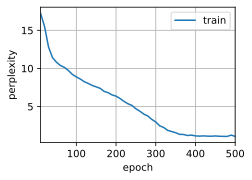

In [9]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 122419.9 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


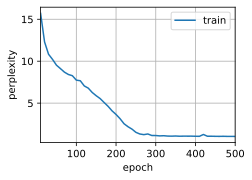

In [10]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Summary
* Gated RNNs can better caputre dependencies for sequences with large time step distances.

* Reset gates help capture short-term dependencies in sequences.

* Update gates help capture long-term dependencies in sequences.

* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.

## 9.2 Long Short-Term Memory(LSTM)


In [11]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [12]:
def get_lstm_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size = shape, device = device) * 0.01
  
  def three():
    return (normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device = device)
            )
  
  W_xi, W_hi, b_i = three() # Input gate parameters
  W_xf, W_hf, b_f = three() # Forget gate parameters
  W_xo, W_ho, b_o = three() # Output gate parameters
  W_xc, W_hc, b_c = three() # Candidate memory cell parameters
  # Output layer parameters
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device = device)
  # Attach gradients
  params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [13]:
def init_lstm_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device = device),
          torch.zeros((batch_size, num_hiddens), device = device))

In [14]:
def lstm(inputs, state, params):
  [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
  (H, C) = state
  outputs = []
  for X in inputs:
    I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
    F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
    O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
    C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
    C = F * C + I * C_tilda
    H = O * torch.tanh(C)
    Y = (H @ W_hq) + b_q
    outputs.append(Y)

  return torch.cat(outputs, dim = 0), (H, C)

perplexity 1.1, 23751.1 tokens/sec on cuda:0
time traveller we the breww yoong man thoughtin which case they 
traveller the pausereduin time fir that is all shigen explo


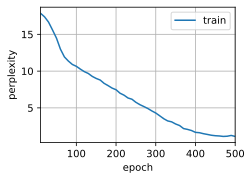

In [15]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 103463.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


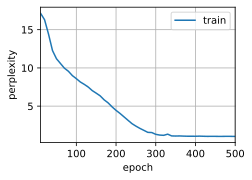

In [16]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Summary
* LSTMs have three types of gates: input gates, forget gates, and output gates that control the flow of information.

* The hidden layer output of LSTM includes the hidden state and the memory cell. Only the hidden state is passed into the output layer. The memory cell is entirely internal.

* LSTMs can alleviate vanishing and exploding gradients.

## 9.3 Deep Recurrent Neural Networks

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [18]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

perplexity 1.0, 79958.3 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


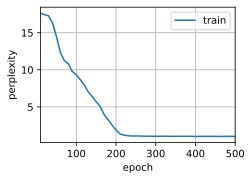

In [19]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Summary
* In deep RNNs, the hidden state information is passed to the next time step of the current layer and the current time step of the next layer.

* There exist many different flavors of deep RNNs, such as LSTMs, GRUs, or vanilla RNNs. Conveniently these models are all available as parts of the high-level APIs of deep learning frameworks.

* Initialization of models requires care. Overall, deep RNNs require considerable amount of work (such as learning rate and clipping) to ensure proper convergence.

## 9.4 Bidirectional Recurrent Neural Networks

perplexity 1.1, 42412.5 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


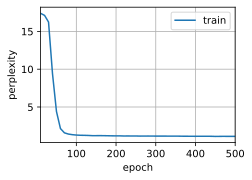

In [20]:
import torch
from torch import nn
from d2l import torch as d2l

# Load data
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the bidirectional LSTM model by setting `bidirectional=True`
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional = True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Summary
* In bidirectional RNNs, the hidden state for each time step is simultaneously determined by the data prior to and after the current time step.

* Bidirectional RNNs bear a striking resemblance with the forward-backward algorithm in probabilistic graphical models.

* Bidirectional RNNs are mostly useful for sequence encoding and the estimation of observations given bidirectional context.

* Bidirectional RNNs are very costly to train due to long gradient chains.